In [1]:
import pandas as pd
import numpy as np
import time
from mip import *
import matplotlib.pyplot as plt

In [2]:
# 读取女性评分
with open("Scores_for_Women.txt", "r") as f:
    w_to_m_data = f.readlines()[1:]

# 转化为矩阵 w_to_m_score_matrix[i][j] 为 女性i对男性j的评分
w_to_m_Scores = []    
for i in range(len(w_to_m_data)):
    w_to_m_Scores.append([float(ii) for ii in w_to_m_data[i].strip('\n').split(' ')[:-1]])
    
w_to_m_score_matrix = np.array(w_to_m_Scores)

# 读取男性评分
with open("Scores_for_Men.txt", "r") as f:
    m_to_w_data = f.readlines()[1:]

# 转化为矩阵 m_to_w_score_matrix[i][j] 为 男性i对女性j的评分    
m_to_w_Scores = []    
for i in range(len(m_to_w_data)):
    m_to_w_Scores.append([float(ii) for ii in m_to_w_data[i].strip('\n').split(' ')[:-1]])
    
m_to_w_score_matrix = np.array(m_to_w_Scores)


# 读取拒绝列表
with open("Reject_List.txt", "r") as f:
    reject_data = f.readlines()[1:]

# 转化为列表 
reject_list = []    
for i in range(len(reject_data)):
    reject_list.append([int(ii) for ii in reject_data[i].strip('\n').split(' ')])
    
# print('reject_list', reject_list)

W_dict = {} # 女性可接受词典
M_dict = {} # 男性可接受词典

for i in range(68):
    W_dict[i] = [i for i in range(68)]
    M_dict[i] = [i for i in range(68)]

for j in reject_list: # 按拒绝列表移除不接受的用户
    W_dict[j[0]].remove(j[1])
    M_dict[j[1]].remove(j[0])


In [3]:
# 使用调和平均数计算 双向评分
weight_matrix = 2/(1/(m_to_w_score_matrix.T) + 1/w_to_m_score_matrix) # weight_matrix[0][1] score between women 1 and men 2


## Gale-Shapley algorithm

In [4]:
def gale_shapley(m_to_w_score_matrix, w_to_m_score_matrix, W_dict, M_dict):
    n = m_to_w_score_matrix.shape[0]  # number of men (or women)
    unmatched_men = list(range(n))  # initially all men are unmatched
    m_matched = [-1] * n  # who m is matched to
    w_matched = [-1] * n  # who w is matched to

    m_next_choice = [0] * n  # which woman to match next

    while unmatched_men:
        m = unmatched_men.pop() # remove and return the last man from the unmatched_men list
        preferences = sorted(W_dict[m], key=lambda x: -m_to_w_score_matrix[m][x]) # sorting in descending order
        w = preferences[m_next_choice[m]] # man chooses the next woman on his list to match
        m_next_choice[m] += 1 # update the next choice

        # if w is not matched or she prefers m over her current matching
        if w_matched[w] == -1 or w_to_m_score_matrix[w][m] > w_to_m_score_matrix[w][w_matched[w]]:
            # if w is currently matched, her previous matching m becomes unmatched
            if w_matched[w] != -1:
                unmatched_men.append(w_matched[w])
            # matched m and w
            w_matched[w] = m
            m_matched[m] = w
        else:
            # if w doesn't prefer m, m remains unmatched
            unmatched_men.append(m)

    return m_matched  # this gives for each man, his matched woman

In [5]:
start_time = time.time()
matched_pairs_gs = gale_shapley(m_to_w_score_matrix, w_to_m_score_matrix, W_dict, M_dict)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Gale-Shapley function took {elapsed_time:.4f} seconds to run.")

GS_solution = [[i, matched_pairs_gs[i]] for i in range(len(matched_pairs_gs))]
print(GS_solution)

Gale-Shapley function took 0.0553 seconds to run.
[[0, 51], [1, 15], [2, 45], [3, 7], [4, 16], [5, 40], [6, 59], [7, 56], [8, 48], [9, 28], [10, 22], [11, 47], [12, 0], [13, 3], [14, 46], [15, 9], [16, 26], [17, 6], [18, 41], [19, 37], [20, 13], [21, 12], [22, 4], [23, 32], [24, 62], [25, 55], [26, 31], [27, 57], [28, 38], [29, 64], [30, 42], [31, 21], [32, 19], [33, 49], [34, 63], [35, 50], [36, 36], [37, 18], [38, 20], [39, 35], [40, 65], [41, 34], [42, 61], [43, 25], [44, 23], [45, 53], [46, 27], [47, 43], [48, 8], [49, 54], [50, 52], [51, 30], [52, 2], [53, 14], [54, 29], [55, 5], [56, 58], [57, 66], [58, 11], [59, 33], [60, 39], [61, 17], [62, 60], [63, 1], [64, 44], [65, 24], [66, 10], [67, 67]]


In [6]:
# 根据单向分数矩阵  计算 女性用户 i 在 男性用户 j 中的排名 和 男性用户 j 在 女性用户 i 中的排名

def find_max_position(input_array):
    # 查找数组中最大的数的坐标（可能是多个）
    # 如最大为 -1 则输出 [-1]
    max_number = max(input_array)
    if int(max_number) == -1:
        return [-1]
    index = np.where(max_number == input_array)[0]
    return index

w_m_score = w_to_m_score_matrix.copy()
m_w_score = m_to_w_score_matrix.copy()

w_to_m_rank = np.zeros((68,68))
m_to_w_rank = np.zeros((68,68))



for i in range(68):
    rank = 1
    while rank < 68:

        index_save = find_max_position(w_m_score[i])
#         print(index_save)
        if -1 in index_save:
            break

        for ii in index_save:
            w_m_score[i][ii] = -1
            w_to_m_rank[i][ii] = rank

        rank += 1

        
for i in range(68):
    rank = 1
    while rank < 68:

        index_save = find_max_position(m_w_score[i])
#         print(index_save)
        if -1 in index_save:
            break

        for ii in index_save:
            m_w_score[i][ii] = -1
            m_to_w_rank[i][ii] = rank

        rank += 1

In [7]:
w_to_m_better_or_indiff_than = [[[]for i in range(68)] for j in range(68)] # empty

# women to men
for i in range(68): # women i
    for j in range(68): # men j
        rank = w_to_m_rank[i][j]
        set_of_men = list(np.where(w_to_m_rank[i] <= rank)[0])
        w_to_m_better_or_indiff_than[i][j] = set_of_men
        
for r in reject_list:
    for i in range(68):
        if r[0] == i:
            for j in range(68):
                if r[1] in w_to_m_better_or_indiff_than[i][j]:
                    w_to_m_better_or_indiff_than[i][j].remove(r[1])



m_to_w_better_or_indiff_than = [[[]for i in range(68)] for j in range(68)] # empty
# men to women
for i in range(68): # men i
    for j in range(68): # women j
        rank = m_to_w_rank[i][j]
        set_of_women = list(np.where(m_to_w_rank[i] <= rank)[0])
        m_to_w_better_or_indiff_than[i][j] = set_of_women
        
for r in reject_list:
    for i in range(68):
        if r[1] == i:
            for j in range(68):
                if r[0] in m_to_w_better_or_indiff_than[i][j]:
                    m_to_w_better_or_indiff_than[i][j].remove(r[0])

## Mixed-Integer Programming (MIP)

In [8]:
def MIP_Solver(Optimize_Direction = 'MAXIMIZE', Additional_Const = 'stable', Show_infor = False, OF = 'Maximize Weight'):
    # 最大化权重模型（无稳定性）：Optimize_Direction = 'MAXIMIZE', Additional_Const = 'unstable', OF = 'Maximize Weight' 
    # 稳定性模型：
    # 1.最大化权重：Optimize_Direction = 'MAXIMIZE', Additional_Const = 'stable', OF = 'Maximize Weight' 
    # 2.最小化总rank：Optimize_Direction = 'MINIMIZE', Additional_Const = 'stable', OF = 'Egalitarian'  
    
    
    if Optimize_Direction == 'MAXIMIZE':
        
        SMTI = Model(sense=MAXIMIZE, solver_name=CPLEX)
        
    elif Optimize_Direction == 'MINIMIZE':
        
        SMTI = Model(sense=MINIMIZE, solver_name=CPLEX)
    
    SMTI.verbose = 0
 
    num_female = 68
    num_male = 68

    I = set(range(num_female))
    J = set(range(num_male))

    x = [[SMTI.add_var(var_type=BINARY) for j in J] for i in I] # Decision Variable

    if OF == 'Maximize Weight':
        SMTI.objective = xsum(weight_matrix[i][j]*x[i][j] for i in I for j in W_dict[i])
    elif OF == 'Egalitarian':
        SMTI.objective = xsum((m_to_w_rank[j][i] + w_to_m_rank[i][j])*x[i][j] for i in I for j in W_dict[i])

    for i in I:
        SMTI += xsum(x[i][j] for j in W_dict[i]) <= 1 

    for j in J:
        SMTI += xsum(x[i][j] for i in M_dict[j]) <= 1    

    if Additional_Const == 'stable':
        for i in I:
            for j in W_dict[i]:
                SMTI += 1 - xsum(x[i][q] for q in w_to_m_better_or_indiff_than[i][j]) <= xsum(x[p][j] for p in m_to_w_better_or_indiff_than[j][i])

    start = time.perf_counter()
    status = SMTI.optimize(max_seconds=600)
    end = time.perf_counter()
    runningtime = end-start
    solution = []
    
    if Show_infor == True:
        print('optimal solution score {} found'.format(SMTI.objective_value))
        print('Best Possible:', SMTI.objective_bound)
        print('model has {} vars, {} constraints and {} nzs'.format(SMTI.num_cols, SMTI.num_rows, SMTI.num_nz))
    
    for i in I:
        for j in J:
            if x[i][j].x > 0.99:
                solution.append([i,j])
    
    print('runningtime',runningtime)
    
    return solution, SMTI.objective_value # 匹配结果，模型最优值

In [9]:
def MR(Show_infor = False): 
    # 优化方向：（附带稳定性）最小化最大rank
    
    SMTI = Model(sense=MINIMIZE, solver_name=CPLEX)
    SMTI.verbose = 0

    num_female = 68
    num_male = 68

    I = set(range(num_female))
    J = set(range(num_male))

    x = [[SMTI.add_var(var_type=BINARY) for j in J] for i in I] # Decision Variable
    z = SMTI.add_var()

    SMTI.objective = z # Objective Function


    for i in I:
        SMTI += xsum(x[i][j] for j in W_dict[i]) <= 1 

    for j in J:
        SMTI += xsum(x[i][j] for i in M_dict[j]) <= 1    


    for i in I:
        for j in W_dict[i]:
            SMTI += 1 - xsum(x[i][q] for q in w_to_m_better_or_indiff_than[i][j]) <= xsum(x[p][j] for p in m_to_w_better_or_indiff_than[j][i])

    for i in I:
        for j in W_dict[i]:
            SMTI += m_to_w_rank[j][i]*x[i][j] <= z
            SMTI += w_to_m_rank[i][j]*x[i][j] <= z
    
    start = time.perf_counter()
    status = SMTI.optimize(max_seconds=600)
    end = time.perf_counter()
    runningtime = end-start

    if Show_infor == True:
        print('optimal solution score {} found'.format(SMTI.objective_value))
        print('Best Possible:', SMTI.objective_bound)
        print('model has {} vars, {} constraints and {} nzs'.format(SMTI.num_cols, SMTI.num_rows, SMTI.num_nz))

    solution = []
    
    
    for i in I:
        for j in J:
            if x[i][j].x > 0.99:
                solution.append([i,j])
    print('runningtime',runningtime)                
    return solution, SMTI.objective_value # 匹配结果，模型最优值

In [10]:
def SESM(Show_infor = False):
    # 优化方向：（附带稳定性）最小化男女公平差异
    
    SMTI = Model(sense=MINIMIZE, solver_name=CPLEX)
    SMTI.verbose = 0
       
    num_female = 68
    num_male = 68

    I = set(range(num_female))
    J = set(range(num_male))

    x = [[SMTI.add_var(var_type=BINARY) for j in J] for i in I] # Decision Variable
    z = SMTI.add_var()

    SMTI.objective = z # Objective Function


    for i in I:
        SMTI += xsum(x[i][j] for j in W_dict[i]) <= 1 

    for j in J:
        SMTI += xsum(x[i][j] for i in M_dict[j]) <= 1    


    for i in I:
        for j in W_dict[i]:
            SMTI += 1 - xsum(x[i][q] for q in w_to_m_better_or_indiff_than[i][j]) <= xsum(x[p][j] for p in m_to_w_better_or_indiff_than[j][i])

    SMTI += xsum((m_to_w_rank[j][i] - w_to_m_rank[i][j])*x[i][j] for i in I for j in W_dict[i]) <= z
    
    SMTI += xsum((w_to_m_rank[i][j] - m_to_w_rank[j][i])*x[i][j] for i in I for j in W_dict[i]) <= z
    
    start = time.perf_counter()
    status = SMTI.optimize(max_seconds=600)
    end = time.perf_counter()
    runningtime = end-start

    if Show_infor == True:
        print('optimal solution score {} found'.format(SMTI.objective_value))
        print('Best Possible:', SMTI.objective_bound)
        print('model has {} vars, {} constraints and {} nzs'.format(SMTI.num_cols, SMTI.num_rows, SMTI.num_nz))

    
    solution = []
    
    
    for i in I:
        for j in J:
            if x[i][j].x > 0.99:
                solution.append([i,j])
                
    print('runningtime',runningtime)                
    return solution, SMTI.objective_value # 匹配结果，模型最优值

In [11]:
MAX_WT_solution     =  MIP_Solver(Optimize_Direction = 'MAXIMIZE', Additional_Const = 'unstable', Show_infor=True, OF = 'Maximize Weight' )[0]
MAX_WT_stable_solution =  MIP_Solver(Optimize_Direction = 'MAXIMIZE', Additional_Const = 'stable',Show_infor=True)[0]
Egalitarian_solution= MIP_Solver(Optimize_Direction = 'MINIMIZE', Additional_Const = 'stable', OF = 'Egalitarian',Show_infor=True)[0]
MR_solution         = MR(Show_infor=True)[0]
SESM_solution       = SESM(Show_infor=True)[0]

optimal solution score 3295.0351934700716 found
Best Possible: 3295.0351934700716
model has 4624 vars, 136 constraints and 8844 nzs
runningtime 0.39189717499994003
optimal solution score 3220.7374355831435 found
Best Possible: 3220.737435583144
model has 4624 vars, 4558 constraints and 310628 nzs
runningtime 5.655326418000072
optimal solution score 777.0 found
Best Possible: 777.0
model has 4624 vars, 4558 constraints and 310628 nzs
runningtime 14.95384948700007
optimal solution score 28.0 found
Best Possible: 28.0
model has 4625 vars, 13402 constraints and 328316 nzs
runningtime 13.438923077999789
optimal solution score 70.0 found
Best Possible: 70.0
model has 4625 vars, 4560 constraints and 319164 nzs
runningtime 7.561183111999981


## Evaluations

### Stability check

In [12]:
def is_unstable(pair, solution, m_to_w_Scores, w_to_m_Scores):
    m, w = pair
    m_current_score = m_to_w_Scores[m][w]
    
    for other_w, other_w_score in enumerate(m_to_w_Scores[m]):
        # If other woman has a higher score and they are matched
        if other_w_score > m_current_score and [m, other_w] in solution:
            other_m = [pair[0] for pair in solution if pair[1] == other_w][0]  # get the man paired with other_w
            other_m_score = w_to_m_Scores[other_w][other_m]
            
            if w_to_m_Scores[other_w][m] > other_m_score:
                return True
    
    return False

def count_unstable_matches(solution, m_to_w_Scores, w_to_m_Scores):
    count = 0
    for pair in solution:
        if is_unstable(pair, solution, m_to_w_Scores, w_to_m_Scores):
            count += 1
    return count

In [13]:
# solutions from different algorithms
solutions = {
    'GS': GS_solution,
    'MAX_WT': MAX_WT_solution,
    'MAX_WT_stable': MAX_WT_stable_solution,
    'Egalitarian': Egalitarian_solution,
    'MR': MR_solution,
    'SESM': SESM_solution
}

unstable_counts = {}

for algo, solution in solutions.items():
    count = count_unstable_matches(solution, m_to_w_Scores, w_to_m_Scores)
    unstable_counts[algo] = count

# count of unstable matches for each algorithm
print(unstable_counts)

{'GS': 0, 'MAX_WT': 0, 'MAX_WT_stable': 0, 'Egalitarian': 0, 'MR': 0, 'SESM': 0}


In [14]:
def calculate_scores(matched_pairs, m_to_w_score_matrix, w_to_m_score_matrix):
    total_score_m_to_w = sum([m_to_w_score_matrix[m][w] for m, w in matched_pairs if w != -1])
    total_score_w_to_m = sum([w_to_m_score_matrix[w][m] for m, w in matched_pairs if w != -1])
    
    average_score_m_to_w = total_score_m_to_w / len(matched_pairs)
    average_score_w_to_m = total_score_w_to_m / len(matched_pairs)
    
    return total_score_m_to_w, total_score_w_to_m, average_score_m_to_w, average_score_w_to_m

In [15]:
GS_scores = calculate_scores(GS_solution, m_to_w_score_matrix, w_to_m_score_matrix)
MAX_WT_scores = calculate_scores(MAX_WT_solution, m_to_w_score_matrix, w_to_m_score_matrix)
MAX_WT_stable_scores = calculate_scores(MAX_WT_stable_solution, m_to_w_score_matrix, w_to_m_score_matrix)
Egalitarian_scores = calculate_scores(Egalitarian_solution, m_to_w_score_matrix, w_to_m_score_matrix)
MR_scores = calculate_scores(MR_solution, m_to_w_score_matrix, w_to_m_score_matrix)
SESM_scores = calculate_scores(SESM_solution, m_to_w_score_matrix, w_to_m_score_matrix)

### Total scores

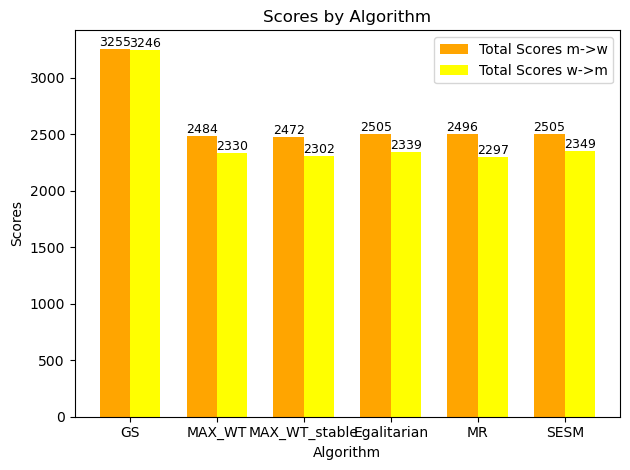

In [16]:
# Data for plotting
algorithms = ['GS', 'MAX_WT', 'MAX_WT_stable', 'Egalitarian', 'MR', 'SESM']
total_scores_m_to_w = [GS_scores[0], MAX_WT_scores[0], MAX_WT_stable_scores[0], Egalitarian_scores[0], MR_scores[0], SESM_scores[0]]
total_scores_w_to_m = [GS_scores[1], MAX_WT_scores[1], MAX_WT_stable_scores[1], Egalitarian_scores[1], MR_scores[1], SESM_scores[1]]

# Bar plots
bar_width = 0.35
index = range(len(algorithms))
fig, ax = plt.subplots()

bar1 = ax.bar(index, total_scores_m_to_w, bar_width, label='Total Scores m->w', color='orange')
bar2 = ax.bar([i+bar_width for i in index], total_scores_w_to_m, bar_width, label='Total Scores w->m', color='yellow')

ax.set_xlabel('Algorithm')
ax.set_ylabel('Scores')
ax.set_title('Scores by Algorithm')
ax.set_xticks([i+bar_width/2 for i in index])
ax.set_xticklabels(algorithms)
ax.legend()

# Function to add scores on top of the bars
def add_scores_on_bars(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{int(height)}', 
                ha='center', va='bottom', fontsize=9)

add_scores_on_bars(bar1, ax)
add_scores_on_bars(bar2, ax)

plt.tight_layout()
plt.savefig('Total_scores')
plt.show()

### Scores differences

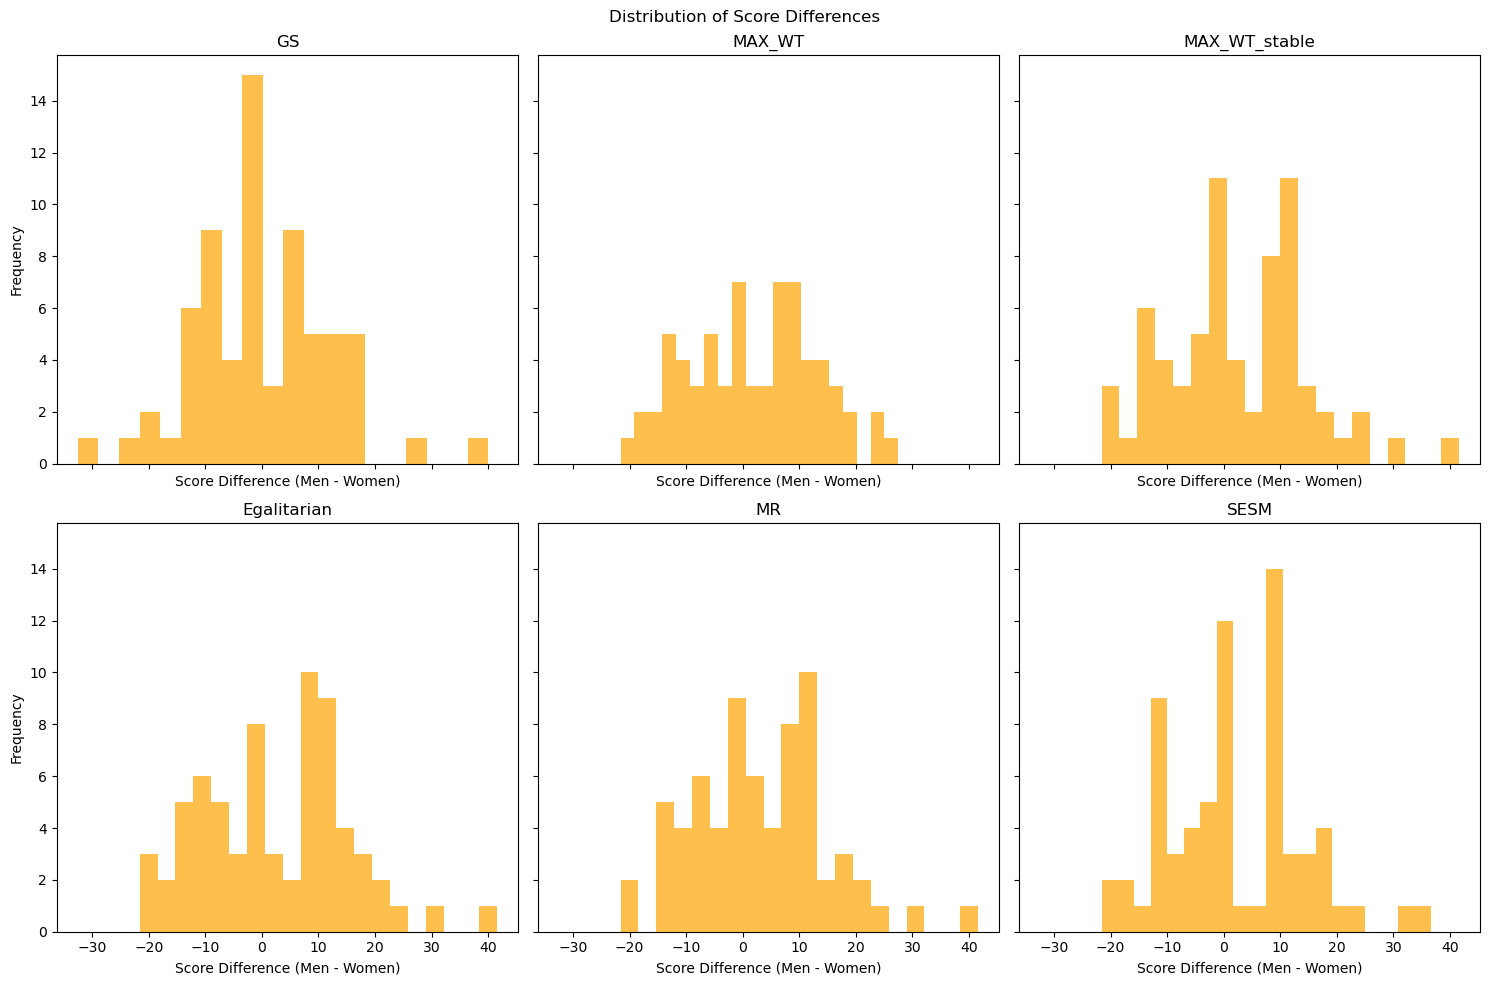

In [17]:
def plot_score_differences_comparison(solutions, m_to_w_score_matrix, w_to_m_score_matrix, names):
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
    fig.suptitle('Distribution of Score Differences')
    
    # Flatten axes for easy iteration
    axes_flat = axes.flatten()
    
    # Iterate over each solution and its corresponding subplot axis
    for idx, (solution, ax) in enumerate(zip(solutions, axes_flat)):
        differences = [m_to_w_score_matrix[pair[0]][pair[1]] - w_to_m_score_matrix[pair[1]][pair[0]] for pair in solution]
        
        ax.hist(differences, bins=20, color='orange', alpha=0.7)
        ax.set_title(names[idx])
        ax.set_xlabel('Score Difference (Men - Women)')
        
        # Only set the y-label for the first and fourth plots (being the first plot of each row)
        if idx == 0 or idx == 3:
            ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('Score Differences Comparison')
    plt.show()

# List of solutions and their names
solutions = [GS_solution, MAX_WT_solution, MAX_WT_stable_solution, Egalitarian_solution, MR_solution, SESM_solution]
solution_names = ['GS', 'MAX_WT', 'MAX_WT_stable', 'Egalitarian', 'MR', 'SESM']

# Generate the subplot
plot_score_differences_comparison(solutions, m_to_w_score_matrix, w_to_m_score_matrix, solution_names)

### Ranks

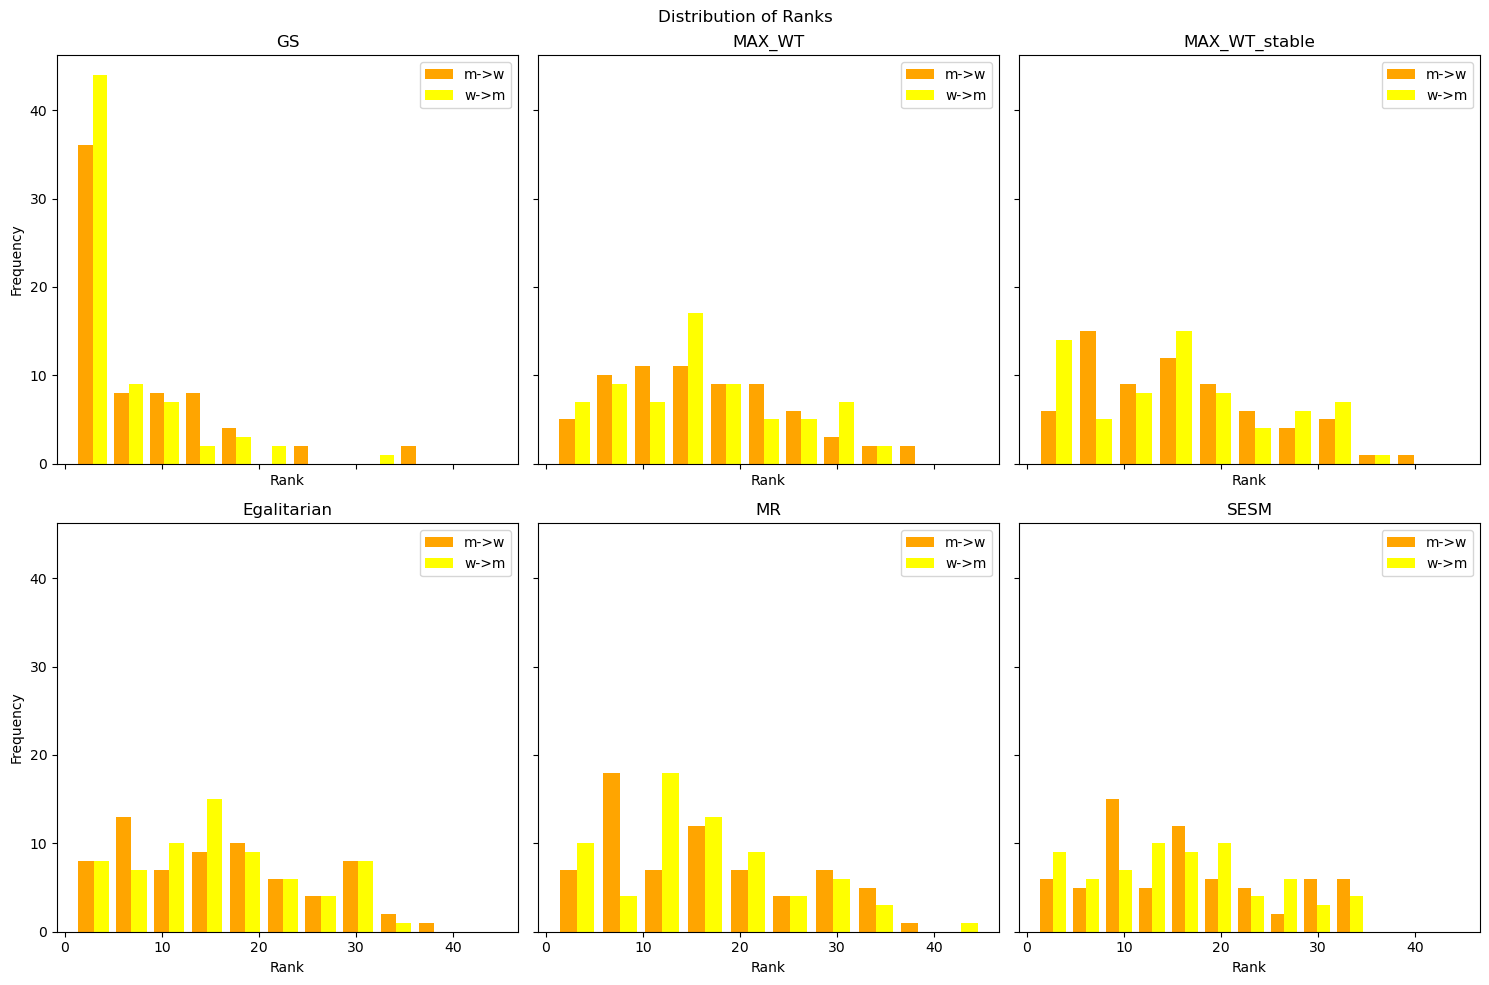

In [18]:
def plot_ranks_comparison(solutions, m_to_w_rank, w_to_m_rank, names):
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
    fig.suptitle('Distribution of Ranks')

    # Flatten axes for easy iteration
    axes_flat = axes.flatten()
    
    # Iterate over each solution and its corresponding subplot axis
    for idx, (solution, ax) in enumerate(zip(solutions, axes_flat)):
        men_ranks = [m_to_w_rank[pair[0]][pair[1]] for pair in solution]
        women_ranks = [w_to_m_rank[pair[1]][pair[0]] for pair in solution]
        
        ax.hist([men_ranks, women_ranks], color=['orange', 'yellow'], label=['m->w', 'w->m'], bins=10)
        ax.legend(loc="upper right")
        ax.set_title(names[idx])
        ax.set_xlabel('Rank')
        
        # Only set the y-label for the first and fourth plots (being the first plot of each row)
        if idx == 0 or idx == 3:
            ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('Distribution of Ranks')
    plt.show()

# List of solutions and their names
solutions = [GS_solution, MAX_WT_solution, MAX_WT_stable_solution, Egalitarian_solution, MR_solution, SESM_solution]
solution_names = ['GS', 'MAX_WT', 'MAX_WT_stable', 'Egalitarian', 'MR', 'SESM']

# Generate the subplot
plot_ranks_comparison(solutions, m_to_w_rank, w_to_m_rank, solution_names)

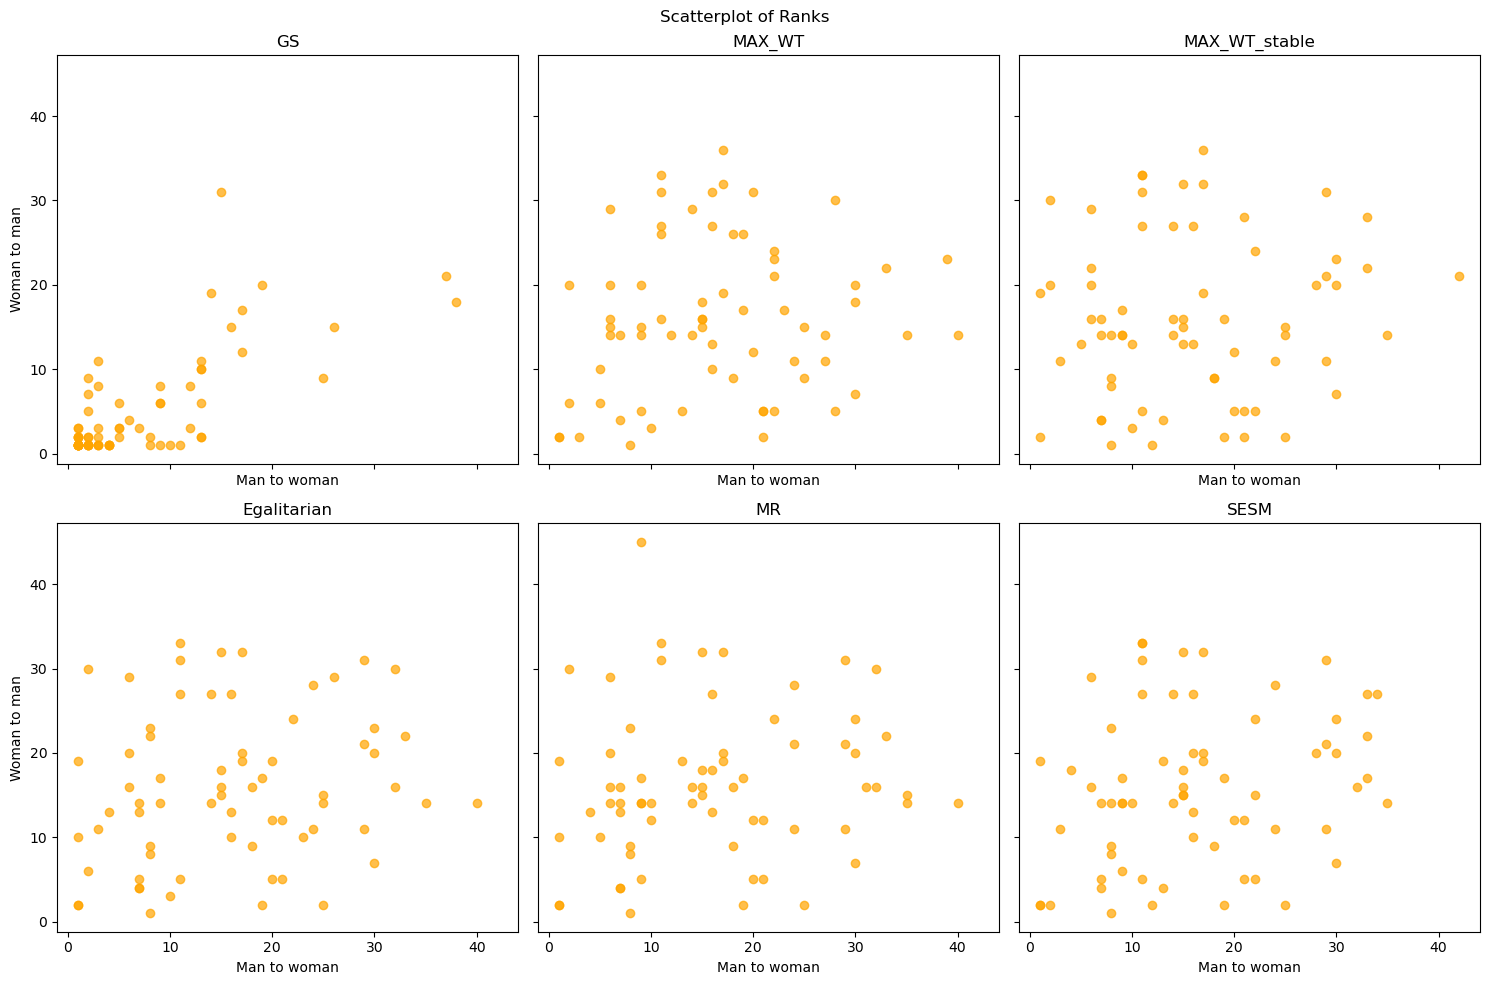

In [19]:
def plot_ranks_scatter(solutions, m_to_w_rank, w_to_m_rank, names):
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
    fig.suptitle('Scatterplot of Ranks')

    # Flatten axes for easy iteration
    axes_flat = axes.flatten()
    
    # Iterate over each solution and its corresponding subplot axis
    for idx, (solution, ax) in enumerate(zip(solutions, axes_flat)):
        men_ranks = [m_to_w_rank[pair[0]][pair[1]] for pair in solution]
        women_ranks = [w_to_m_rank[pair[1]][pair[0]] for pair in solution]
        
        ax.scatter(men_ranks, women_ranks, color='orange', alpha=0.7)
        ax.set_title(names[idx])
        ax.set_xlabel('Man to woman')
        
        # Only set the y-label for the first and fourth plots (being the first plot of each row)
        if idx == 0 or idx == 3:
            ax.set_ylabel('Woman to man')
    
    plt.tight_layout()
    plt.savefig('Scatterplot of Ranks')
    plt.show()

# List of solutions and their names
solutions = [GS_solution, MAX_WT_solution, MAX_WT_stable_solution, Egalitarian_solution, MR_solution, SESM_solution]
solution_names = ['GS', 'MAX_WT', 'MAX_WT_stable', 'Egalitarian', 'MR', 'SESM']

# Generate the subplot
plot_ranks_scatter(solutions, m_to_w_rank, w_to_m_rank, solution_names)

### Ranks differences

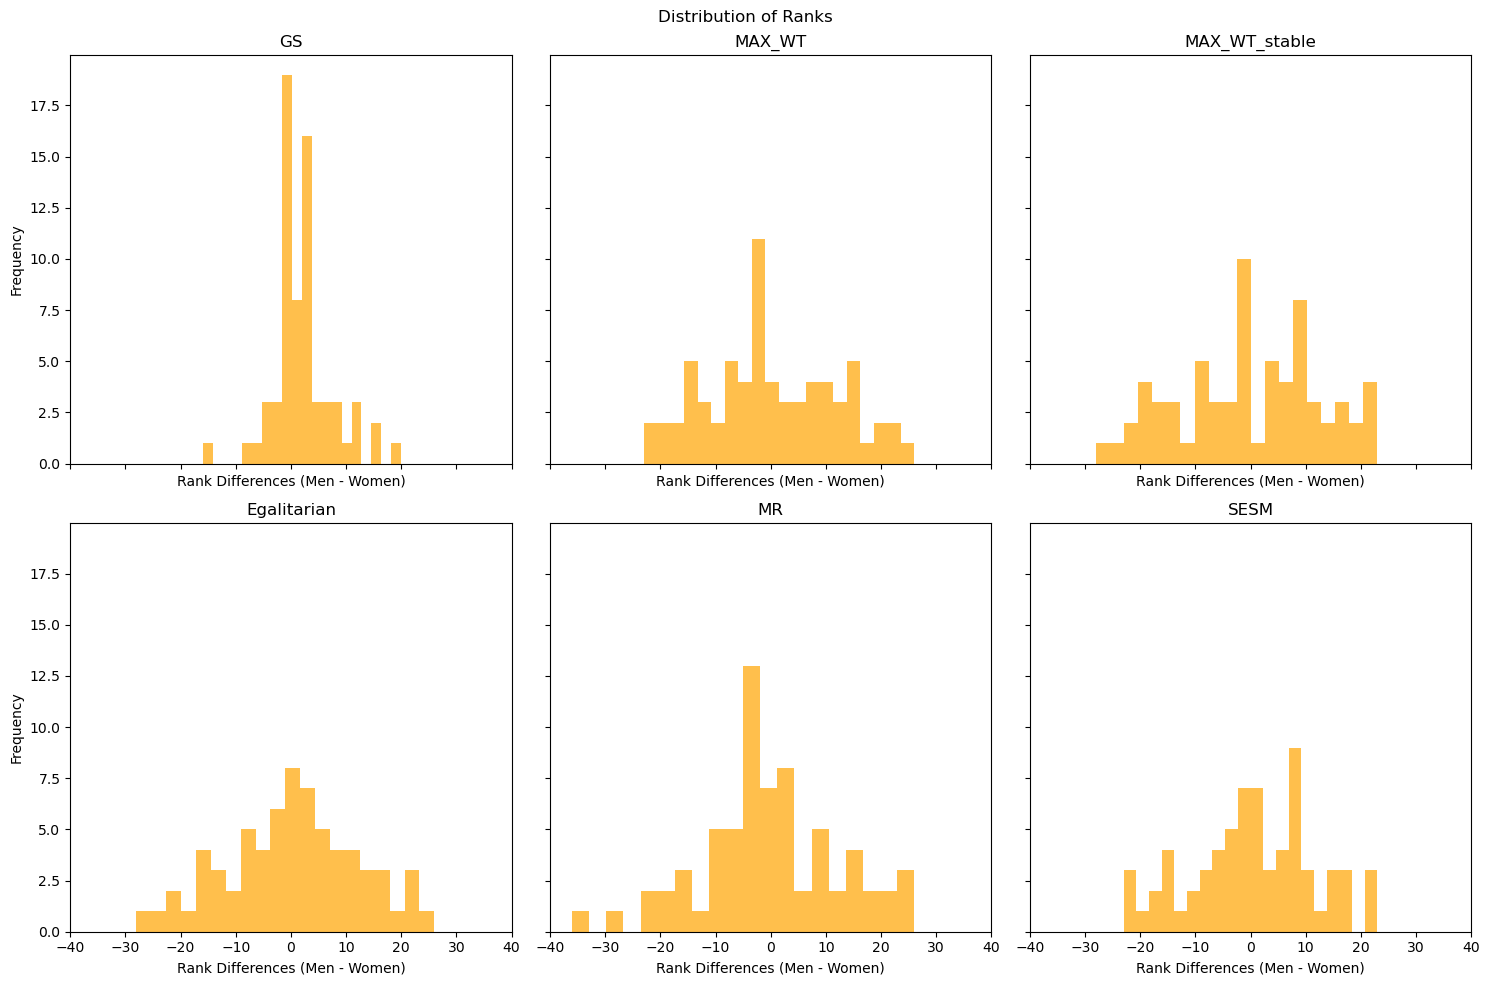

In [20]:
def plot_ranks_differences_comparison(solutions, m_to_w_rank, w_to_m_rank, names):
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
    fig.suptitle('Distribution of Ranks')

    # Flatten axes for easy iteration
    axes_flat = axes.flatten()
    
    # Iterate over each solution and its corresponding subplot axis
    for idx, (solution, ax) in enumerate(zip(solutions, axes_flat)):
        rank_diffs = [m_to_w_rank[pair[0]][pair[1]] - w_to_m_rank[pair[1]][pair[0]] for pair in solution]
        ax.hist(rank_diffs, color='orange', bins=20, alpha=0.7)
        ax.set_xlim(-40,40)
        ax.set_title(names[idx])
        ax.set_xlabel('Rank Differences (Men - Women)')
        
        # Only set the y-label for the first and fourth plots (being the first plot of each row)
        if idx == 0 or idx == 3:
            ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('Distribution of Ranks Differences')
    plt.show()

# List of solutions and their names
solutions = [GS_solution, MAX_WT_solution, MAX_WT_stable_solution, Egalitarian_solution, MR_solution, SESM_solution]
solution_names = ['GS', 'MAX_WT', 'MAX_WT_stable', 'Egalitarian', 'MR', 'SESM']

plot_ranks_differences_comparison(solutions, m_to_w_rank, w_to_m_rank, solution_names)